**ICCAD 2012 Dataset**

**Dataset: ICCAD-2012**

You can download the ICCAD-2012 dataset as a ZIP file from the following link: [ICCAD-2012](https://drive.google.com/file/d/1lawhHhiJklrrgr2SlO172n1X69XRnsM1/view?usp=share_link) Download.

Please note that the file is large (approximately 136 MB), so there is no need to extract it after downloading. Simply download the ZIP file and upload it directly to your Google Drive in the location where you intend to access it later.

**Example:**
In my Google Drive, I have a folder named Coin-3D, which contains another folder called Lithograph. I uploaded the ZIP file directly into the Lithograph folder.



How the ICCAD Dataset looks like?
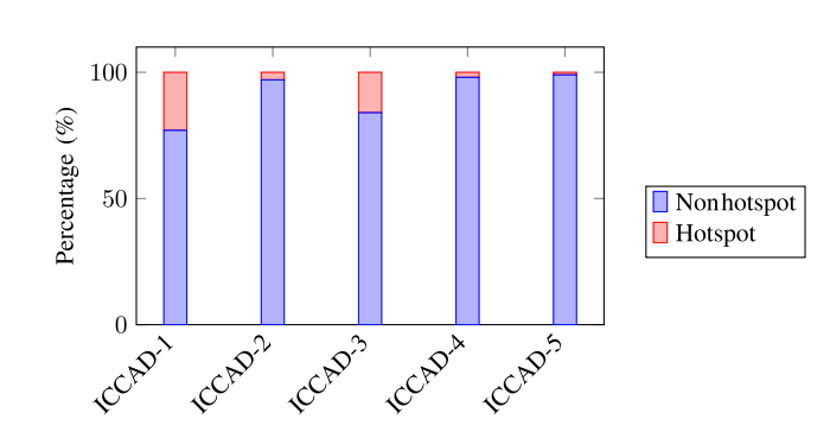



**Google Drive Access**

To access files stored in your Google Drive from this notebook, you first need to mount your Google Drive. This connects your Drive to the Colab environment so you can read or write files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Extracts a .rar file from  Google Drive**

This command extracts a .rar file from your Google Drive into the Colab working directory.
!unrar x tells Colab to use the unrar tool to extract the file.
The path after it is the location of the .rar file in your Drive, and -d /content/ sets the destination folder for the extracted contents.

In [ ]:
!unrar x /content/drive/MyDrive/Coin-3D/Lithography/iccad_official.rar -d /content/


Streaming output truncated to the last 5000 lines.
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png3.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png4.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png6.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png7.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png8.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png9.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5744.png1.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5744.png2.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5744.png3.png      97%  OK 
Extracting  /content/iccad-official/icca

**Step 1: Import**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.utils as vutils


**Generator and Discriminator Networks**

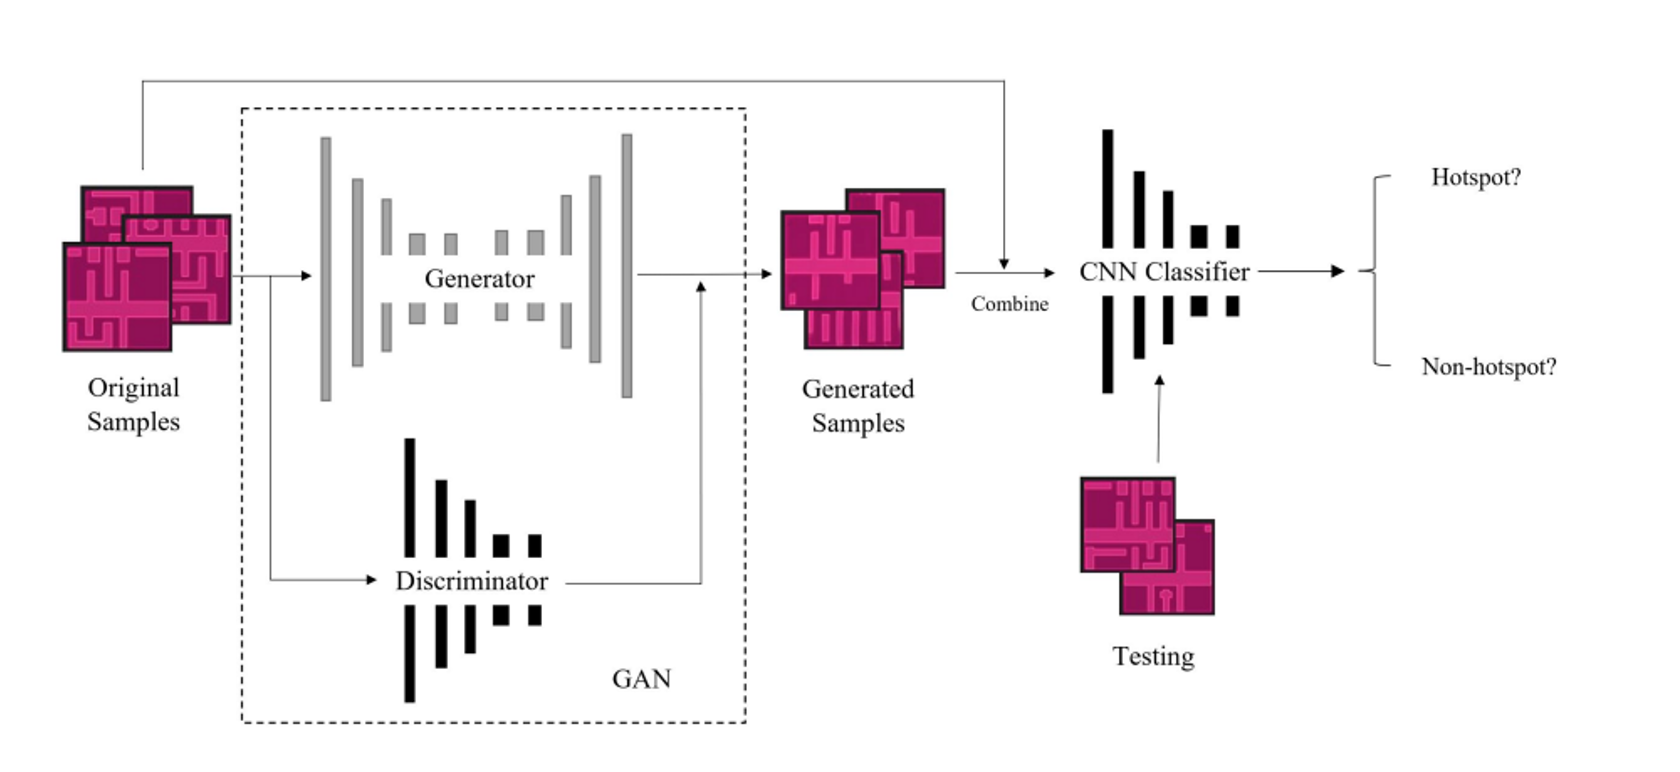[link text](https://)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 3 * 64 * 64),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(z.size(0), 3, 64, 64)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 64 * 64, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)


 **Step 3: Dataset Loader (Same as Before, with Resize to 64×64):**

In [ ]:
class MultiICCADLayoutDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.transform = transform
        self.samples = []
        for i in range(1, 6):  # ICCAD1 to ICCAD5
            iccad_path = os.path.join(base_dir, f"iccad{i}", "train")
            for class_name in ["train_nhs", "train_hs"]:
                class_dir = os.path.join(iccad_path, class_name)
                if not os.path.exists(class_dir): continue
                for file in os.listdir(class_dir):
                    if file.lower().endswith((".png", ".jpg", ".jpeg")):
                        self.samples.append(os.path.join(class_dir, file))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


**Step 4: Transforms and Dataloader:**

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = MultiICCADLayoutDataset("/content/iccad-official", transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)



**Step 5: Initialize GAN and Optimizers:**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

def weights_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

generator.apply(weights_init)
discriminator.apply(weights_init)

adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00005)  # lower LR for D


**Step 6: Training Loop**

[Epoch 1/5000] D loss: 0.3235 | G loss: 1.9028
[Epoch 2/5000] D loss: 0.2014 | G loss: 5.2427
[Epoch 3/5000] D loss: 0.1862 | G loss: 6.6816
[Epoch 4/5000] D loss: 0.1718 | G loss: 7.2599
[Epoch 5/5000] D loss: 0.1676 | G loss: 7.5709
[Epoch 6/5000] D loss: 0.1660 | G loss: 7.4999
[Epoch 7/5000] D loss: 0.1638 | G loss: 6.8491
[Epoch 8/5000] D loss: 0.1642 | G loss: 7.7757
[Epoch 9/5000] D loss: 0.1643 | G loss: 7.8131
[Epoch 10/5000] D loss: 0.1641 | G loss: 6.1474
[Epoch 11/5000] D loss: 0.1638 | G loss: 7.6364
[Epoch 12/5000] D loss: 0.1660 | G loss: 5.2134
[Epoch 13/5000] D loss: 0.1630 | G loss: 8.2913
[Epoch 14/5000] D loss: 0.1629 | G loss: 9.4715
[Epoch 15/5000] D loss: 0.1629 | G loss: 10.1248
[Epoch 16/5000] D loss: 0.1628 | G loss: 10.4835
[Epoch 17/5000] D loss: 0.1628 | G loss: 10.7238
[Epoch 18/5000] D loss: 0.1628 | G loss: 10.9432
[Epoch 19/5000] D loss: 0.1628 | G loss: 11.1560
[Epoch 20/5000] D loss: 0.1629 | G loss: 8.1111


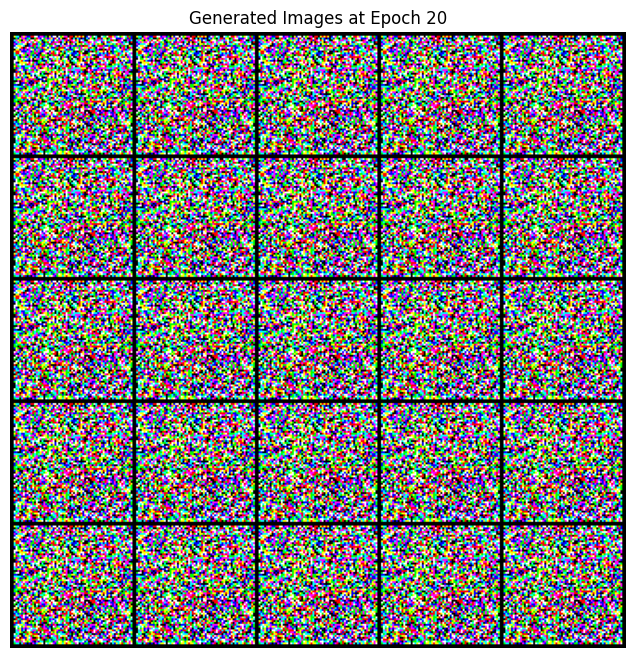

[Epoch 21/5000] D loss: 0.1630 | G loss: 7.1441
[Epoch 22/5000] D loss: 0.1628 | G loss: 8.7818
[Epoch 23/5000] D loss: 0.1628 | G loss: 9.7840
[Epoch 24/5000] D loss: 0.1628 | G loss: 9.8230
[Epoch 25/5000] D loss: 0.1627 | G loss: 10.5334
[Epoch 26/5000] D loss: 0.1627 | G loss: 11.2807
[Epoch 27/5000] D loss: 0.1627 | G loss: 11.4995
[Epoch 28/5000] D loss: 0.1627 | G loss: 8.9205
[Epoch 29/5000] D loss: 0.1627 | G loss: 10.7837
[Epoch 30/5000] D loss: 0.1627 | G loss: 8.0735
[Epoch 31/5000] D loss: 0.1631 | G loss: 7.0781
[Epoch 32/5000] D loss: 0.1628 | G loss: 9.1610
[Epoch 33/5000] D loss: 0.1632 | G loss: 8.8176
[Epoch 34/5000] D loss: 0.1627 | G loss: 9.9078
[Epoch 35/5000] D loss: 0.1627 | G loss: 11.3149
[Epoch 36/5000] D loss: 0.1627 | G loss: 8.7983
[Epoch 37/5000] D loss: 0.1628 | G loss: 8.3989
[Epoch 38/5000] D loss: 0.1626 | G loss: 11.0095
[Epoch 39/5000] D loss: 0.1627 | G loss: 11.8341
[Epoch 40/5000] D loss: 0.1626 | G loss: 12.2113


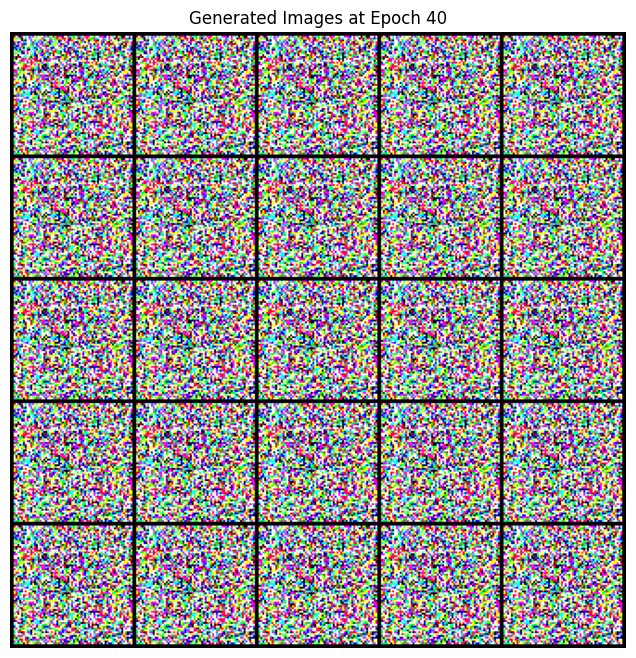

[Epoch 41/5000] D loss: 0.1626 | G loss: 9.5584
[Epoch 42/5000] D loss: 0.1627 | G loss: 11.4980
[Epoch 43/5000] D loss: 0.1626 | G loss: 12.1276
[Epoch 44/5000] D loss: 0.1626 | G loss: 12.5384
[Epoch 45/5000] D loss: 0.1626 | G loss: 12.3284
[Epoch 46/5000] D loss: 0.1627 | G loss: 10.6471
[Epoch 47/5000] D loss: 0.1626 | G loss: 11.9327
[Epoch 48/5000] D loss: 0.1626 | G loss: 12.5508
[Epoch 49/5000] D loss: 0.1626 | G loss: 12.7398
[Epoch 50/5000] D loss: 0.1626 | G loss: 13.0999
[Epoch 51/5000] D loss: 0.1626 | G loss: 13.3501
[Epoch 52/5000] D loss: 0.1626 | G loss: 13.4770
[Epoch 53/5000] D loss: 0.1626 | G loss: 13.2967
[Epoch 54/5000] D loss: 0.1630 | G loss: 7.8480
[Epoch 55/5000] D loss: 0.1627 | G loss: 10.3022
[Epoch 56/5000] D loss: 0.1626 | G loss: 12.2188
[Epoch 57/5000] D loss: 0.1626 | G loss: 13.0557
[Epoch 58/5000] D loss: 0.1626 | G loss: 12.9248
[Epoch 59/5000] D loss: 0.1626 | G loss: 9.8340
[Epoch 60/5000] D loss: 0.1626 | G loss: 11.9485


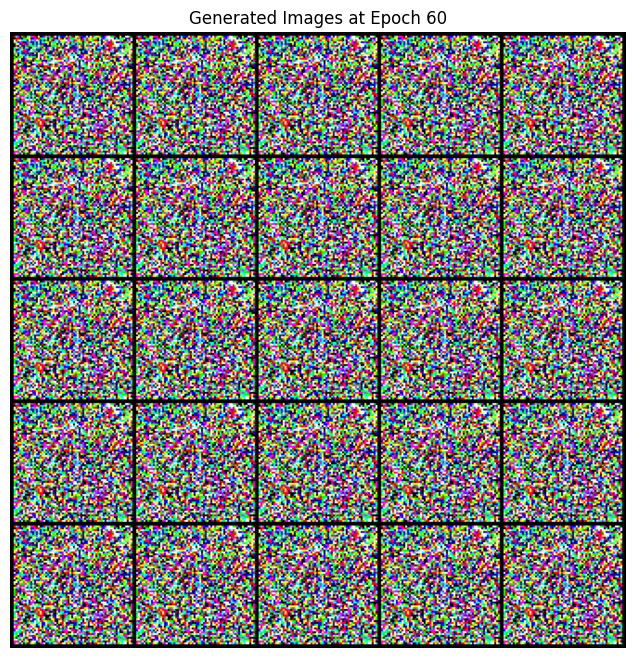

[Epoch 61/5000] D loss: 0.1626 | G loss: 13.0407
[Epoch 62/5000] D loss: 0.1626 | G loss: 13.5352
[Epoch 63/5000] D loss: 0.1626 | G loss: 13.6531
[Epoch 64/5000] D loss: 0.1626 | G loss: 12.0232
[Epoch 65/5000] D loss: 0.1626 | G loss: 13.0801
[Epoch 66/5000] D loss: 0.1626 | G loss: 13.4148
[Epoch 67/5000] D loss: 0.1626 | G loss: 13.7357
[Epoch 68/5000] D loss: 0.1626 | G loss: 13.9151
[Epoch 69/5000] D loss: 0.1626 | G loss: 13.9907
[Epoch 70/5000] D loss: 0.1626 | G loss: 13.9829
[Epoch 71/5000] D loss: 0.1628 | G loss: 10.7394
[Epoch 72/5000] D loss: 0.1626 | G loss: 12.4489
[Epoch 73/5000] D loss: 0.1626 | G loss: 13.0268
[Epoch 74/5000] D loss: 0.1626 | G loss: 13.5252
[Epoch 75/5000] D loss: 0.1626 | G loss: 13.7927
[Epoch 76/5000] D loss: 0.1626 | G loss: 13.9012
[Epoch 77/5000] D loss: 0.1625 | G loss: 13.7275
[Epoch 78/5000] D loss: 0.1628 | G loss: 8.1066
[Epoch 79/5000] D loss: 0.1626 | G loss: 12.2456
[Epoch 80/5000] D loss: 0.1626 | G loss: 13.3014


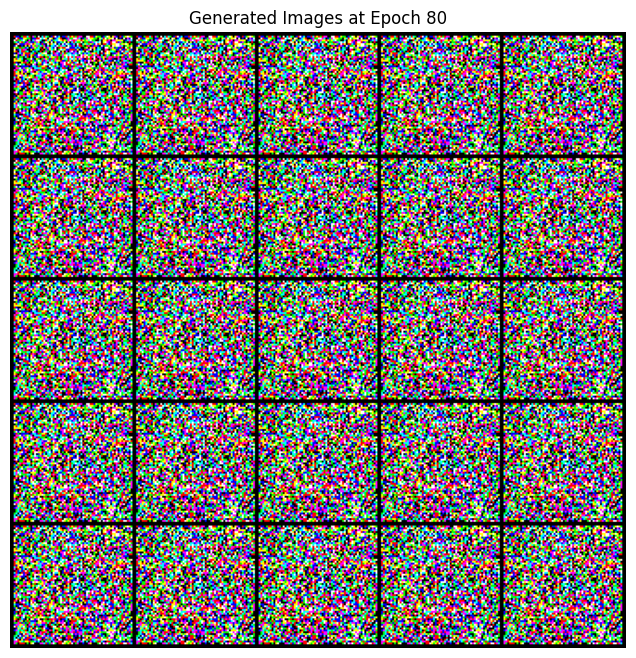

[Epoch 81/5000] D loss: 0.1626 | G loss: 13.8831
[Epoch 82/5000] D loss: 0.1626 | G loss: 14.0660
[Epoch 83/5000] D loss: 0.1626 | G loss: 14.3571
[Epoch 84/5000] D loss: 0.1626 | G loss: 14.3819
[Epoch 85/5000] D loss: 0.1626 | G loss: 14.1807
[Epoch 86/5000] D loss: 0.1626 | G loss: 14.2988


In [ ]:
epochs = 5000
for epoch in range(epochs):
    for i, imgs in enumerate(dataloader):
        real_imgs = imgs.to(device)
        valid = torch.full((imgs.size(0), 1), 0.9, device=device)  # label smoothing
        fake = torch.zeros((imgs.size(0), 1), device=device)

        # -------- Train Generator --------
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim, device=device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # -------- Train Discriminator --------
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    # Print progress
    print(f"[Epoch {epoch+1}/{epochs}] D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f}")

    # -------- Plot generated images every 20 epochs --------
    if (epoch + 1) % 20 == 0:
        generator.eval()
        with torch.no_grad():
            z = torch.randn(25, latent_dim, device=device)
            sample_imgs = generator(z).cpu()
        grid = vutils.make_grid(sample_imgs, nrow=5, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title(f"Generated Images at Epoch {epoch+1}")
        plt.imshow(grid.permute(1, 2, 0))
        plt.show()
        generator.train()



image.png